In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette(['#376CA8', '#25A37B', '#E44574', '#796E9C'])
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [3]:
from snapanalysis.models.ptm_response.main import OUTPUT_FILE as PTM_RESPONSE_FILE

from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER
predictors = PREDICTOR_ORDER

limma_results = pd.read_hdf(PTM_RESPONSE_FILE, '/ptm_stats/joint_limma_stats')
predictors_from_limma = limma_results.reset_index()['predictor'].unique()
assert all(p in predictors_from_limma for p in predictors)
assert all(p in predictors for p in predictors_from_limma)

long_matrices = {}
informative_pds = {}


with pd.HDFStore(PTM_RESPONSE_FILE, 'r') as store: 
    enrichment_complexes = store['/ptm_stats/joint_camera_complexes']
    
    
    for predictor in predictors:
        long_matrices[predictor] = lm = store[f'/ptm_stats/{predictor}/long_matrix']
        informative_pds[predictor] = sorted(lm['Pull-Down ID'].unique())
            

We first create a matrix of logFC estimates for each of the proteins
Keeping only the proteins that are significant (and large FC) in at least 1 predictor

In [4]:
import palettable

In [5]:
matrix_wide = limma_results.unstack('predictor')

In [6]:
# Take logFCs
values = 'logFC'
matrix_for_clustering = matrix_wide[values]

# That are significant (and large FC)
significant = 'significant_and_large_fc'
matrix_for_clustering_mask = matrix_wide[significant]
# In at least one Pull-Down
matrix_for_clustering = matrix_for_clustering[matrix_for_clustering_mask.fillna(False).any(axis=1)]
matrix_for_clustering_mask = matrix_for_clustering_mask.loc[matrix_for_clustering.index]

# Keep the adjusted p-values as well (for later)
matrix_for_clustering_pvalues = matrix_wide['adj.P.Val']



In [7]:
matrix_for_clustering.shape

(352, 15)

We export the table here as the clustering was done by a collaborator outside of this pipeline:

In [8]:
matrix_for_clustering.to_csv(os.path.join(OUTPUT_DIRECTORY, 
                                          'feature_effect_matrix_logfc_significant_and_large_fc.csv.gz'))

In [9]:
matrix_for_clustering.head()

predictor,DNA Methylation,H2A.Z,H3K27ac,H3K27me2,H3K27me3,H3K4me1,H3K4me3,H3K9acK14ac,H3K9me2,H3K9me3,H3ac,H4K16ac,H4K20me2,H4K20me3,H4ac
Gene label,,,,,,,,,,,,,,,
ABRAXAS1,0.163045,-0.044655,-0.025077,-0.108107,-0.028023,-0.027805,-0.615761,0.279407,-0.317315,-0.031382,0.651735,0.128807,-1.542280,-1.030552,0.326409
ACTB,-0.320098,-0.329969,0.892759,0.025224,-0.018707,0.038612,0.158745,1.394101,0.082701,0.063382,1.551879,0.222802,0.400986,-0.018131,0.749387
ACTG1,-0.311329,-0.317037,0.869404,-0.175051,-0.003373,0.062595,0.184102,1.329178,0.114768,-0.002173,1.496575,0.165277,0.329240,-0.092759,0.765680
ACTL6A,-0.549713,-0.674949,1.122702,-0.048410,-0.016357,0.031056,0.165403,1.222988,-0.115009,-0.005260,1.299292,0.209469,0.296015,-0.003559,0.810472
ACTL8,NaN,-0.279445,NaN,NaN,-0.205593,-0.515323,-1.282069,0.853441,NaN,2.254572,1.273351,0.139838,0.220932,-0.005635,0.395663


We magically load the results from clustering of the above matrix which gives us the cluster number, 
cluster prototype and the new order of the matrix:

In [10]:
cluster_prototypes = pd.read_csv('prototype-clustering/cluster_prototypes.tsv', sep='\t')
cluster_prototypes = cluster_prototypes[cluster_prototypes.columns.difference(['Unnamed: 0'])].set_index('protein.label')

In [11]:
assert set(cluster_prototypes.index) == set(matrix_for_clustering.index)

In [12]:
col_order =   ['H2A.Z', 'DNA Methylation',
               'H3K4me1', 'H3K4me3',
               'H3ac', 'H3K9acK14ac', 'H3K27ac',
               'H3K9me2', 'H3K9me3',
               'H3K27me2', 'H3K27me3',
               'H4ac', 'H4K16ac',
               'H4K20me2', 'H4K20me3']

In [13]:
df_reordered = matrix_for_clustering.loc[cluster_prototypes.index, col_order]

df_pval_reordered = matrix_for_clustering_pvalues.loc[cluster_prototypes.index, col_order]


In [14]:
df_reordered.head()

predictor,H2A.Z,DNA Methylation,H3K4me1,H3K4me3,H3ac,H3K9acK14ac,H3K27ac,H3K9me2,H3K9me3,H3K27me2,H3K27me3,H4ac,H4K16ac,H4K20me2,H4K20me3
protein.label,,,,,,,,,,,,,,,
"HIST1H2A[B,E]/HIST3H2A",-1.348211,0.104842,0.109047,0.233460,-0.256282,-0.203934,0.007204,-0.104004,-0.159720,-0.087776,-0.075138,0.022761,0.100861,-0.148157,0.074460
CTDSPL2,-2.796458,0.000284,0.006155,-0.370427,0.148136,0.148891,0.026252,-0.255585,0.000332,-0.117810,-0.012142,0.323940,0.282104,-0.069936,-0.039430
MBD4,-1.208159,0.736324,0.005802,-0.362645,0.348605,0.176215,0.057405,-0.109656,0.082071,0.002300,-0.100958,0.372197,0.085517,0.129583,-0.075633
FBXL6,-1.166444,0.292089,0.311083,0.444522,0.082897,0.073067,-0.173693,-0.030723,0.419949,0.033444,-0.111587,0.504030,0.097994,-0.110660,0.057359
SP110,-1.148665,-0.748757,-0.035713,-0.119921,0.771974,0.580345,-0.038373,0.049713,0.028426,-0.042975,-0.086177,0.223346,0.058809,-0.049826,0.082264


In [15]:
df_pval_reordered.head()

predictor,H2A.Z,DNA Methylation,H3K4me1,H3K4me3,H3ac,H3K9acK14ac,H3K27ac,H3K9me2,H3K9me3,H3K27me2,H3K27me3,H4ac,H4K16ac,H4K20me2,H4K20me3
protein.label,,,,,,,,,,,,,,,
"HIST1H2A[B,E]/HIST3H2A",0.001409,3.077158e-01,0.592342,0.154629,1.305146e-02,3.250487e-02,0.995865,0.625193,0.254538,0.864967,0.730125,0.934420,0.760322,0.364115,0.870680
CTDSPL2,0.000005,9.985477e-01,0.985153,0.038809,1.336198e-01,2.045425e-01,0.990502,0.284372,0.999279,0.815255,0.966249,0.013011,0.102798,0.451293,0.872744
MBD4,0.000028,7.951024e-16,0.979842,0.017457,1.800096e-05,1.305683e-02,0.970360,0.457004,0.426753,0.991547,0.224883,0.002333,0.738351,0.012465,0.420564
FBXL6,0.000045,3.302937e-08,0.004026,0.016017,4.269825e-01,5.450332e-01,0.490935,0.763251,0.006161,0.902958,0.548852,0.002988,0.729509,0.060598,0.573345
SP110,0.000113,7.920632e-12,0.770447,0.156983,1.516764e-09,6.791907e-12,0.977491,0.826937,0.857473,0.954202,0.468804,0.011684,0.723282,0.526191,0.643602


Now load extra info that will go into the table, see Table Proteins notebook for more

In [16]:
from snapanalysis.preprocessing.protein_metadata import get_generic_metadata, get_complex_memberships

complex_memberships = get_complex_memberships()
complex_memberships = complex_memberships.groupby(level='Gene label').apply(lambda x: ';'.join(sorted(set(x))))
complex_memberships.name = 'Complex'

In [17]:
protein_metadata = get_generic_metadata().join(complex_memberships)
# Cheat a bit and have gene label twice. will make it easier
protein_metadata['Gene label'] = protein_metadata.index

protein_metadata = protein_metadata[['Gene label', 'symbol', 'alias', 'name', 'Complex']].rename(columns={'symbol': 'Symbol',
                                                                                            'alias': 'Other Names', 
                                                                                            'name': 'Name'})

protein_metadata = protein_metadata.fillna('').astype(str)
protein_metadata = protein_metadata.loc[df_reordered.index]

In [18]:
protein_metadata

,Gene label,Symbol,Other Names,Name,Complex
protein.label,,,,,
"HIST1H2A[B,E]/HIST3H2A","HIST1H2A[B,E]/HIST3H2A",HIST1H2AE;HIST1H2AB;HIST3H2A,H2A.1;H2A.2;H2A/a;H2A/m;H2AFA;H2AFM,histone cluster 1 H2A family member e;histone ...,
CTDSPL2,CTDSPL2,CTDSPL2,HSPC058;HSPC129,CTD small phosphatase like 2,
MBD4,MBD4,MBD4,MED1,"methyl-CpG binding domain 4, DNA glycosylase",
FBXL6,FBXL6,FBXL6,FBL6;FBL6A;PP14630,F-box and leucine rich repeat protein 6,SCF
SP110,SP110,SP110,IFI41;IFI75;IPR1;VODI,SP110 nuclear body protein,
G2E3,G2E3,G2E3,KIAA1333;PHF7B,G2/M-phase specific E3 ubiquitin protein ligase,
SUB1,SUB1,SUB1,P15;PC4;p14,SUB1 regulator of transcription,
SMC1A,SMC1A,SMC1A,CDLS2;DXS423E;SB1.8;SMC1;SMC1L1;SMC1alpha;SMCB,structural maintenance of chromosomes 1A,Cohesin
TOP2A,TOP2A,TOP2A,TOP2;TP2A,DNA topoisomerase II alpha,


In [19]:
protein_metadata.tail()

,Gene label,Symbol,Other Names,Name,Complex
protein.label,,,,,
KAT2A,KAT2A,KAT2A,GCN5;GCN5L2;PCAF-b;hGCN5,lysine acetyltransferase 2A,ATAC;SAGA;TFTC
TADA3,TADA3,TADA3,ADA3;NGG1;STAF54;TADA3L;hADA3,transcriptional adaptor 3,ATAC;PCAF;SAGA;TFTC
SGF29,SGF29,SGF29,CCDC101;STAF36;TDRD29,SAGA complex associated factor 29,ATAC;SAGA
ZZZ3,ZZZ3,ZZZ3,ATAC1,zinc finger ZZ-type containing 3,ATAC
YEATS2,YEATS2,YEATS2,,YEATS domain containing 2,ATAC


In [20]:
_protein_meta = protein_metadata
_cluster_prototypes = cluster_prototypes[['prototype']].rename(columns={"prototype": "Cluster"})
_df_reordered = df_reordered.copy()
_df_reordered.columns = 'log2fc_' + _df_reordered.columns

_df_pval_reordered = df_pval_reordered.copy()
_df_pval_reordered.columns = 'padj_' + _df_pval_reordered.columns

onwrite_renames = {**dict(zip(_df_reordered.columns, df_reordered.columns)),
                   **dict(zip(_df_pval_reordered.columns, df_pval_reordered.columns))}

df_excel = protein_metadata.join(_cluster_prototypes).join(_df_reordered).join(_df_pval_reordered).loc[_cluster_prototypes.index]

df_excel.head()

,Gene label,Symbol,Other Names,Name,Complex,Cluster,log2fc_H2A.Z,log2fc_DNA Methylation,log2fc_H3K4me1,log2fc_H3K4me3,...,padj_H3K9acK14ac,padj_H3K27ac,padj_H3K9me2,padj_H3K9me3,padj_H3K27me2,padj_H3K27me3,padj_H4ac,padj_H4K16ac,padj_H4K20me2,padj_H4K20me3
protein.label,,,,,,,,,,,,,,,,,,,,,
"HIST1H2A[B,E]/HIST3H2A","HIST1H2A[B,E]/HIST3H2A",HIST1H2AE;HIST1H2AB;HIST3H2A,H2A.1;H2A.2;H2A/a;H2A/m;H2AFA;H2AFM,histone cluster 1 H2A family member e;histone ...,,CTDSPL2,-1.348211,0.104842,0.109047,0.233460,...,3.250487e-02,0.995865,0.625193,0.254538,0.864967,0.730125,0.934420,0.760322,0.364115,0.870680
CTDSPL2,CTDSPL2,CTDSPL2,HSPC058;HSPC129,CTD small phosphatase like 2,,CTDSPL2,-2.796458,0.000284,0.006155,-0.370427,...,2.045425e-01,0.990502,0.284372,0.999279,0.815255,0.966249,0.013011,0.102798,0.451293,0.872744
MBD4,MBD4,MBD4,MED1,"methyl-CpG binding domain 4, DNA glycosylase",,CTDSPL2,-1.208159,0.736324,0.005802,-0.362645,...,1.305683e-02,0.970360,0.457004,0.426753,0.991547,0.224883,0.002333,0.738351,0.012465,0.420564
FBXL6,FBXL6,FBXL6,FBL6;FBL6A;PP14630,F-box and leucine rich repeat protein 6,SCF,CTDSPL2,-1.166444,0.292089,0.311083,0.444522,...,5.450332e-01,0.490935,0.763251,0.006161,0.902958,0.548852,0.002988,0.729509,0.060598,0.573345
SP110,SP110,SP110,IFI41;IFI75;IPR1;VODI,SP110 nuclear body protein,,SP110,-1.148665,-0.748757,-0.035713,-0.119921,...,6.791907e-12,0.977491,0.826937,0.857473,0.954202,0.468804,0.011684,0.723282,0.526191,0.643602


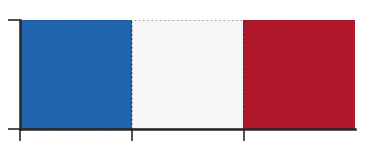

In [21]:
palette = sns.color_palette('RdBu_r', 9).as_hex()
blue = palette[0]
red = palette[-1]
white = palette[4]

sns.palplot([blue, white, red])

In [22]:
from snapanalysis.models.ptm_response.main import FDR_THRESHOLD_RESPONSE
FDR_THRESHOLD_RESPONSE

0.01

In [23]:
import xlsxwriter
from xlsxwriter.utility import xl_rowcol_to_cell


output_excel_filename = os.path.join(OUTPUT_DIRECTORY, 'ptm-response-heatmap.xlsx')

writer = pd.ExcelWriter(output_excel_filename, engine='xlsxwriter')
workbook  = writer.book

format_header_level_two = workbook.add_format({'bold': True})
format_header_level_two.set_bottom(1) # add border
# format_header_level_two.set_shrink()

format_header_level_one = workbook.add_format({'bold': True})
format_header_level_one.set_right(1) # add border

format_header_level_two_corner = workbook.add_format({'bold': True})
# format_header_level_two_corner.set_shrink()
format_header_level_two_corner.set_right(1) # add border
format_header_level_two_corner.set_bottom(1) # add border

format_bold = workbook.add_format({'bold': True})

# Format for groups - border
format_group_right_edge = workbook.add_format()
format_group_right_edge.set_right(1)

format_group_top_edge = workbook.add_format()
format_group_top_edge.set_top(1)

format_group_top_right_edge = workbook.add_format()
format_group_top_right_edge.set_top(1)
format_group_top_right_edge.set_right(1)

format_twodigits = workbook.add_format({'num_format': '0.00'})

vmin = -1.5
vmax = 1.5

conditional_format_options = {
  'type': '3_color_scale',
  'min_value': vmin,
  'max_value': vmax,
  'mid_value': 0,
  'min_type': 'num',
  'max_type': 'num',
  'mid_type': 'num',
  'min_color': blue,
  'mid_color': white,
  'max_color': red
}


first_row_data = 2
last_row_data = first_row_data + len(df_excel)  - 1


sheet_name = 'Heatmap'

# Dump the data first
df_excel.to_excel(writer, 
                  sheet_name=sheet_name,
                  startrow=first_row_data,
                  index=False, header=False)
worksheet = writer.sheets[sheet_name]

separator_cols = {'Complex', 'Cluster', _df_reordered.columns[-1], _df_pval_reordered.columns[-1]}

col_lookup = {}

# Write columns (second level headers)
for i, col in enumerate(df_excel.columns):
    if col in separator_cols:
        format_ = format_header_level_two_corner
    else:
        format_ = format_header_level_two
    
    col_name = onwrite_renames.get(col, col)
    worksheet.write_string(1, i, col_name, format_)
    col_lookup[col] = i
    
# Write merged column_groups (first level headers)
worksheet.merge_range(0, 0, 0, col_lookup['Complex'], 'Metadata',
                     format_header_level_one)
worksheet.merge_range(0, col_lookup[_df_reordered.columns[0]], 
                      0, col_lookup[_df_reordered.columns[-1]], 
                      f'log2(FC) estimates, cells with adjusted P-value <= {FDR_THRESHOLD_RESPONSE} are bolded',
                     format_header_level_one)

worksheet.merge_range(0, col_lookup[_df_pval_reordered.columns[0]], 
                      0, col_lookup[_df_pval_reordered.columns[-1]], 
                      f'P values (adjusted), values <= {FDR_THRESHOLD_RESPONSE} are bolded',
                     format_header_level_one)


for col in separator_cols:
    worksheet.set_column(col_lookup[col], 
                         col_lookup[col], 
                         cell_format=format_group_right_edge)

# Add lines between clusters
prev_cluster = None
for excel_row_i, (ix, row) in enumerate(df_excel.iterrows(), start=first_row_data):
    _cluster = row['Cluster']
    if prev_cluster is not None and prev_cluster != _cluster:
        worksheet.set_row(excel_row_i, None, format_group_top_edge)
        
        # Overwrite corner cols (the only way to fix their format)
        for col in separator_cols:
            value = row[col]
            if pd.isnull(value):
                value = ''
            worksheet.write(excel_row_i, col_lookup[col],
                            value, format_group_top_right_edge)
            
    
    prev_cluster = _cluster
        

# Conditional formats
# Heatmap colors
worksheet.conditional_format(first_row_data, col_lookup[_df_reordered.columns[0]],
                         last_row_data, col_lookup[_df_reordered.columns[-1]], 
                         conditional_format_options)

# Bold of significant P-values
worksheet.conditional_format(first_row_data, 
                             col_lookup[_df_pval_reordered.columns[0]], 
                             last_row_data, 
                             col_lookup[_df_pval_reordered.columns[-1]], 
                             {'type':     'cell',
                             'criteria': 'less than or equal to',
                             'value':    FDR_THRESHOLD_RESPONSE,
                             'format':   format_bold})
# Bold of FCs with significant P-values
worksheet.conditional_format(first_row_data, 
                             col_lookup[_df_reordered.columns[0]], 
                             last_row_data, 
                             col_lookup[_df_reordered.columns[-1]], 
                             {'type':     'formula',
                             'criteria': '={}<={}'.format(xl_rowcol_to_cell(first_row_data, col_lookup[_df_pval_reordered.columns[0]]), 
                                                          FDR_THRESHOLD_RESPONSE),
                             'format':   format_bold})

# Extra styling:


worksheet.freeze_panes(first_row_data, col_lookup[_df_reordered.columns[0]])
worksheet.autofilter(first_row_data-1, 0, last_row_data, col_lookup[df_excel.columns[-1]])

worksheet.set_column(col_lookup['Gene label'],
                     col_lookup['Gene label'], 10)

worksheet.set_column(col_lookup['Complex'],
                     col_lookup['Complex'], 25)

worksheet.set_column(col_lookup['Name'],
                     col_lookup['Name'], 30)

writer.save()